# 使用 PyTorch 实现 WaveNet


在本课程中，我们参考了 Google DeepMind 提出的用于音频处理的 [WaveNet 模型架构](https://deepmind.google/discover/blog/wavenet-a-generative-model-for-raw-audio/)。我们的目标是利用更多字符作为上下文，以提升下一个词的预测性能。


## 模型架构


WaveNet 的架构是一种层次化结构，它对最近的上下文元素赋予更高的权重。

下图展示了该架构的示意图：

![WaveNet 架构示意图](./images/wavenet.png)

*图片来源于原始论文*


## 使用 PyTorch 实现全连接模型


本课程首先将上一课的概念改写为 PyTorch 实现。


### 数据集准备


我们将重用上一课中用于生成数据集的代码。


In [38]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
from torch.utils.data import TensorDataset, DataLoader, random_split

%matplotlib inline

In [39]:
# Lecture du dataset
words = open('prenoms.txt', 'r').read().splitlines()
print(words[:8])

['MARIE', 'JEAN', 'PIERRE', 'MICHEL', 'ANDRÉ', 'JEANNE', 'PHILIPPE', 'LOUIS']


In [40]:
words = open('prenoms.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

为了比较性能，我们将上下文长度从 3 增加到 8。这将为我们提供一个基准，因为 WaveNet 模型也将使用长度为 8 的上下文。


In [41]:
block_size = 8 # La longueur du contexte, combien de caractères pour prédire le suivant ?
X, Y = [], []
for k,w in enumerate(words):
  
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix] 
X = torch.tensor(X)
Y = torch.tensor(Y)

In [42]:
dataset=TensorDataset(X, Y)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(TensorDataset(X, Y),[train_size, val_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

### 模型构建与训练


首先，我们将使用 PyTorch 重新实现上一课中的模型。


In [43]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [44]:
class fcn(nn.Module):
  def __init__(self,embed_dim=10,context_len=8,hidden_dim=300, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.embed_dim=embed_dim
    self.context_len=context_len
    
    #La fonction nn.Embedding de pytorch est l'équivalent de la matrice C 
    self.embedding=nn.Embedding(46,embed_dim)
    self.layer1=nn.Linear(embed_dim*context_len,hidden_dim)
    self.layer2=nn.Linear(hidden_dim,46)

  def forward(self,x):       
    embed=self.embedding(x) # Remplace la matrice C
    embed=embed.view(-1,self.embed_dim*self.context_len)
    hidden=F.tanh(self.layer1(embed))
    logits=self.layer2(hidden)
    return logits


In [45]:
model=fcn(context_len=8)
epochs=50
lr=0.2
optimizer=torch.optim.SGD(model.parameters(),lr=lr)
for p in model.parameters():
  p.requires_grad = True

**注意**：
为了完全复现上一课的代码，需要在训练过半时将学习率降低 10 倍。在 PyTorch 中，可以通过 [*scheduler*](https://pytorch.org/docs/stable/optim.html) 实现。常见的 *scheduler* 类型包括：
- *LambdaLR*：根据自定义函数调整学习率
- *StepLR*：每 *n* 个 epoch 降低学习率
- *LinearLR*：线性降低学习率
- *ReduceLROnPlateau*：当损失不再变化时降低学习率
- *OneCycleLR*：先增大后减小学习率

为了加速模型收敛，推荐使用 *OneCycleLR*（详见[此博文](https://www.datacamp.com/tutorial/cyclical-learning-neural-nets)）。若要获得高性能模型，则推荐 *ReduceLROnPlateau*。无论如何，建议您亲自尝试不同的 *scheduler* 以找到最佳方案。


In [46]:
lossi=[]
lossvali=[]
stepi = []
for epoch in range(epochs):
  loss_epoch=0
  for x,y in train_loader:
    # forward pass
    logits=model(x)
    loss = F.cross_entropy(logits, y)
    # retropropagation
    optimizer.zero_grad()
    loss.backward()
    # Mise à jour des poids du modèle
    optimizer.step()
    loss_epoch+=loss
  loss_epoch=loss_epoch/len(train_loader)
  stepi.append(epoch)
  lossi.append(loss_epoch.item())
  
  # Validation
  loss_val=0
  for x,y in val_loader:
    logits=model(x)
    loss = F.cross_entropy(logits, y)
    loss_val+=loss
  loss_val=loss_val/len(val_loader)
  lossvali.append(loss_val.item())
  if epoch%10==0:
    print(f"Epoch {epoch} - Training loss: {loss_epoch.item():.3f}, Validation loss: {loss_val.item():.3f}")

Epoch 0 - Training loss: 2.487, Validation loss: 2.427
Epoch 10 - Training loss: 2.056, Validation loss: 2.151
Epoch 20 - Training loss: 1.952, Validation loss: 2.114
Epoch 30 - Training loss: 1.896, Validation loss: 2.146
Epoch 40 - Training loss: 1.864, Validation loss: 2.092


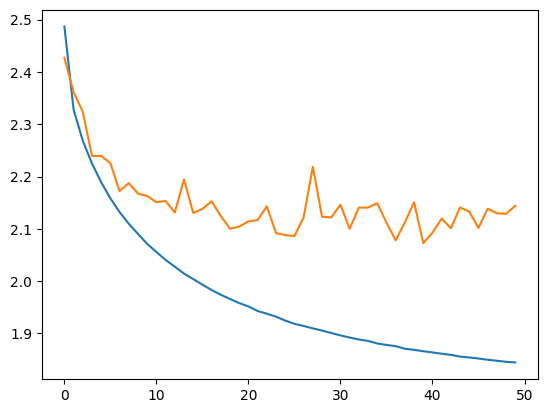

In [47]:
plt.plot(stepi, lossi)
plt.plot(stepi,lossvali)

训练曲线与验证曲线之间的差异表明模型存在轻微过拟合。


In [48]:
# On annule le calcul des gradients car on n'est plus en phase d'entraînement.
model.eval()
loss_test=0
for x,y in test_loader:
    
  # forward pass
  logits=model(x)
  loss = F.cross_entropy(logits, y)
      
  loss_test+=loss
loss_test=loss_test/len(test_loader)
print(loss_test)

tensor(2.1220, grad_fn=<DivBackward0>)


测试损失略高于训练损失，说明模型存在轻微过拟合，但程度较轻，且仍有空间进一步扩展网络容量。现在我们可以检查生成名字的质量。


In [49]:
for _ in range(5):
  out = []
  context = [0] * block_size 
  while True:
    logits=model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  
  print(''.join(itos[i] for i in out))

LOUIS-ANDRÉ.
YOHES.
BRES.
TERIGAND.
CONKHE.


生成的名字尚可，但仍有改进空间。接下来我们尝试用 WaveNet 方法在测试数据上获得更低的损失。


## 使用 PyTorch 实现 WaveNet


数据集与上一部分相同，无需做任何修改。


### 如何实现层次化架构


在我们的模型中，我们希望并行处理由连续字符组成的 *embedding* 组。在 PyTorch 中，若将一个形状为 $B \times L \times C$ 的张量输入一个 $C \times H$ 的线性层，会得到一个形状为 $B \times L \times H$ 的张量，这正是实现 WaveNet 网络所需的操作。


接下来，我们需要调整张量的形状以实现 WaveNet 的层次化操作。我们的 8 个 *embedding* 首先两两分组并行处理，在下一层再次两两分组。因此，每一步中，$H$（或 $C$）的维度加倍，$L$ 的维度减半。

具体来说，第一步中我们有一个形状为 $B \times 8 \times 10$ 的张量，需要将其转换为形状为 $B \times 4 \times 20$ 的张量。这可以通过 PyTorch 的 [*view()*](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html) 方法实现。


In [50]:
dummy=torch.randn([256,8,10])
# On divise par deux L et on double H/C
dummy=dummy.view(-1,dummy.shape[1]//2,dummy.shape[2]*2)
print(dummy.shape)

torch.Size([256, 4, 20])


我们尝试将其封装为一个可复用的网络层：


In [51]:
class FlattenConsecutive(nn.Module):
  # n est le facteur de regroupement (toujours 2 pour nous)
  def __init__(self, n):
    super(FlattenConsecutive, self).__init__()
    self.n = n   
  def __call__(self, x):
    # On récupère les dimensions de l'entrée
    B, T, C = x.shape 
    # On fait la transformation x2 et /2
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1: 
      x = x.squeeze(1) # Si le tensor a une dimension qui vaut 1, on la supprime
    self.out = x
    return self.out

### 构建模型


现在我们开始构建模型。为了简化代码，我们使用 [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) 来组织各层。


In [52]:
class wavenet(nn.Module):
  def __init__(self,embed_dim=10,hidden_dim=128, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    
    self.net=nn.Sequential(nn.Embedding(46,embed_dim),
      # B*8*10
      FlattenConsecutive(2), nn.Linear(embed_dim*2,hidden_dim),nn.Tanh(),
      # B*4*hidden_dim
      FlattenConsecutive(2), nn.Linear(hidden_dim*2,hidden_dim),nn.Tanh(),
      # B*2*hidden_dim
      FlattenConsecutive(2), nn.Linear(hidden_dim*2,hidden_dim),nn.Tanh(),
      # B*hidden_dim
      nn.Linear(hidden_dim,46)
    )   
        
  def forward(self,x):
    logits=self.net(x)
    return logits


初始化模型及超参数。


In [53]:
model=wavenet()
epochs=40
lr=0.2
optimizer=torch.optim.SGD(model.parameters(),lr=lr)
for p in model.parameters():
  p.requires_grad = True

启动训练过程。


In [54]:
lossi=[]
lossvali=[]
stepi = []
for epoch in range(epochs):
  loss_epoch=0
  for x,y in train_loader:
    logits=model(x)
    loss = F.cross_entropy(logits, y)
    # retropropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Mise à jour des poids du modèle
    loss_epoch+=loss
  loss_epoch=loss_epoch/len(train_loader)
  stepi.append(epoch)
  lossi.append(loss_epoch.item())
  
  # Validation
  loss_val=0
  for x,y in val_loader:
    logits=model(x)
    loss = F.cross_entropy(logits, y)
    loss_val+=loss
  loss_val=loss_val/len(val_loader)
  lossvali.append(loss_val.item())
  if epoch%10==0:
    print(f"Epoch {epoch} - Training loss: {loss_epoch.item():.3f}, Validation loss: {loss_val.item():.3f}")
  

Epoch 0 - Training loss: 2.541, Validation loss: 2.459
Epoch 10 - Training loss: 2.013, Validation loss: 2.094
Epoch 20 - Training loss: 1.898, Validation loss: 2.096
Epoch 30 - Training loss: 1.834, Validation loss: 2.060


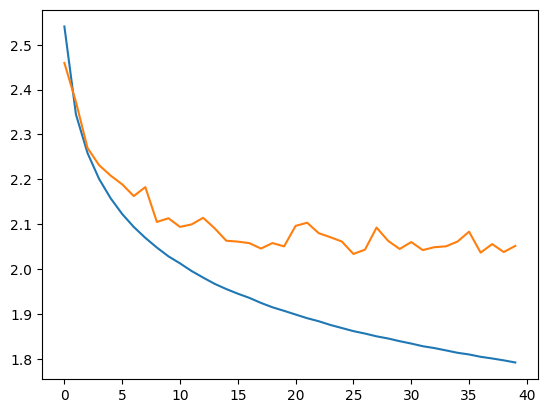

In [55]:
plt.plot(stepi, lossi)
plt.plot(stepi,lossvali)

In [56]:
model.eval()
loss_test=0
for x,y in test_loader:
      
  # forward pass
  logits=model(x)
  loss = F.cross_entropy(logits, y)
      
  loss_test+=loss
loss_test=loss_test/len(test_loader)
print(loss_test)

tensor(2.0132, grad_fn=<DivBackward0>)


我们得到了一个优秀的损失值，且低于上下文长度为 8 的全连接模型。

**注意**：
观察验证曲线与训练曲线，可能存在一些问题（上下文长度为 8 的全连接模型也有类似现象）。您可以尝试利用之前课程中学到的知识来解决这个问题（参考[全连接网络课程](../02_RéseauFullyConnected/README.md)）。


In [68]:
for _ in range(5):
  out = []
  context = [0] * block_size 
  while True:
    logits=model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  
  print(''.join(itos[i] for i in out))

MARICE.
JEXE.
RAYEDE.
CHAHI.
RISHAE.


生成的名字质量越来越高！


**练习**：
为了提升技能，您可以尝试调整训练参数、网络架构等，以在测试数据上获得低于 2.0 的损失。若能同时减少模型参数量，将获得额外奖励。
